#MNIST digit recognition using SVC and PCA with Polynomial kernel

#> Using optimal parameters, fit to BOTH original and deskewed data
---

In [1]:
from __future__ import division
import os, time, math
import cPickle as pickle

import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv

from operator import itemgetter
from tabulate import tabulate

from print_imgs import print_imgs # my own function to print a grid of square images

from sklearn.preprocessing    import StandardScaler
from sklearn.utils            import shuffle
from sklearn.decomposition    import PCA

from sklearn.svm              import SVC

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search      import RandomizedSearchCV

from sklearn.metrics          import classification_report, confusion_matrix

np.random.seed(seed=1009)

%matplotlib inline

In [2]:
#%qtconsole  

##Where's the data?

In [3]:
file_path = '../data/'

train_img_deskewed_filename = 'train-images_deskewed.csv'
train_img_original_filename = 'train-images.csv'

test_img_deskewed_filename  = 't10k-images_deskewed.csv'
test_img_original_filename  = 't10k-images.csv'
    
train_label_filename   = 'train-labels.csv'
test_label_filename    = 't10k-labels.csv'

##How much of the data will we use?

In [4]:
portion = 1.0  # set to less than 1.0 for testing; set to 1.0 to use the entire dataset

##Read the training images and labels, both original and deskewed

In [5]:
# read both trainX files
with open(file_path + train_img_original_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainXo = np.ascontiguousarray(data, dtype = np.float64)  

with open(file_path + train_img_deskewed_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainXd = np.ascontiguousarray(data, dtype = np.float64)

# vertically concatenate the two files
trainX = np.vstack((trainXo, trainXd))

trainXo = None
trainXd = None

# read trainY twice and vertically concatenate
with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainYo = np.ascontiguousarray(data, dtype = np.int8) 
trainYd = np.ascontiguousarray(data, dtype = np.int8)

trainY = np.vstack((trainYo, trainYd)).ravel()

trainYo = None
trainYd = None
data    = None

# shuffle trainX & trainY
trainX, trainY = shuffle(trainX, trainY, random_state=0)

# use less data if specified
if portion < 1.0:
    trainX = trainX[:portion*trainX.shape[0]]
    trainY = trainY[:portion*trainY.shape[0]]

    
print("trainX shape: {0}".format(trainX.shape))
print("trainY shape: {0}\n".format(trainY.shape))

print(trainX.flags)

trainX shape: (120000, 784)
trainY shape: (120000,)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


##Read the DESKEWED test images and labels

In [6]:
# read testX
with open(file_path + test_img_deskewed_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.ascontiguousarray(data, dtype = np.float64)  

# read testY
with open(file_path + test_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testY = np.ascontiguousarray(data, dtype = np.int8)

# shuffle testX, testY
testX, testY = shuffle(testX, testY, random_state=0)

# use a smaller dataset if specified
if portion < 1.0:
    testX = testX[:portion*testX.shape[0]]
    testY = testY[:portion*testY.shape[0]]

print("testX shape: {0}".format(testX.shape))
print("testY shape: {0}".format(testY.shape))

testX shape: (10000, 784)
testY shape: (10000, 1)


#Use the smaller, fewer images for testing

##Print a sample

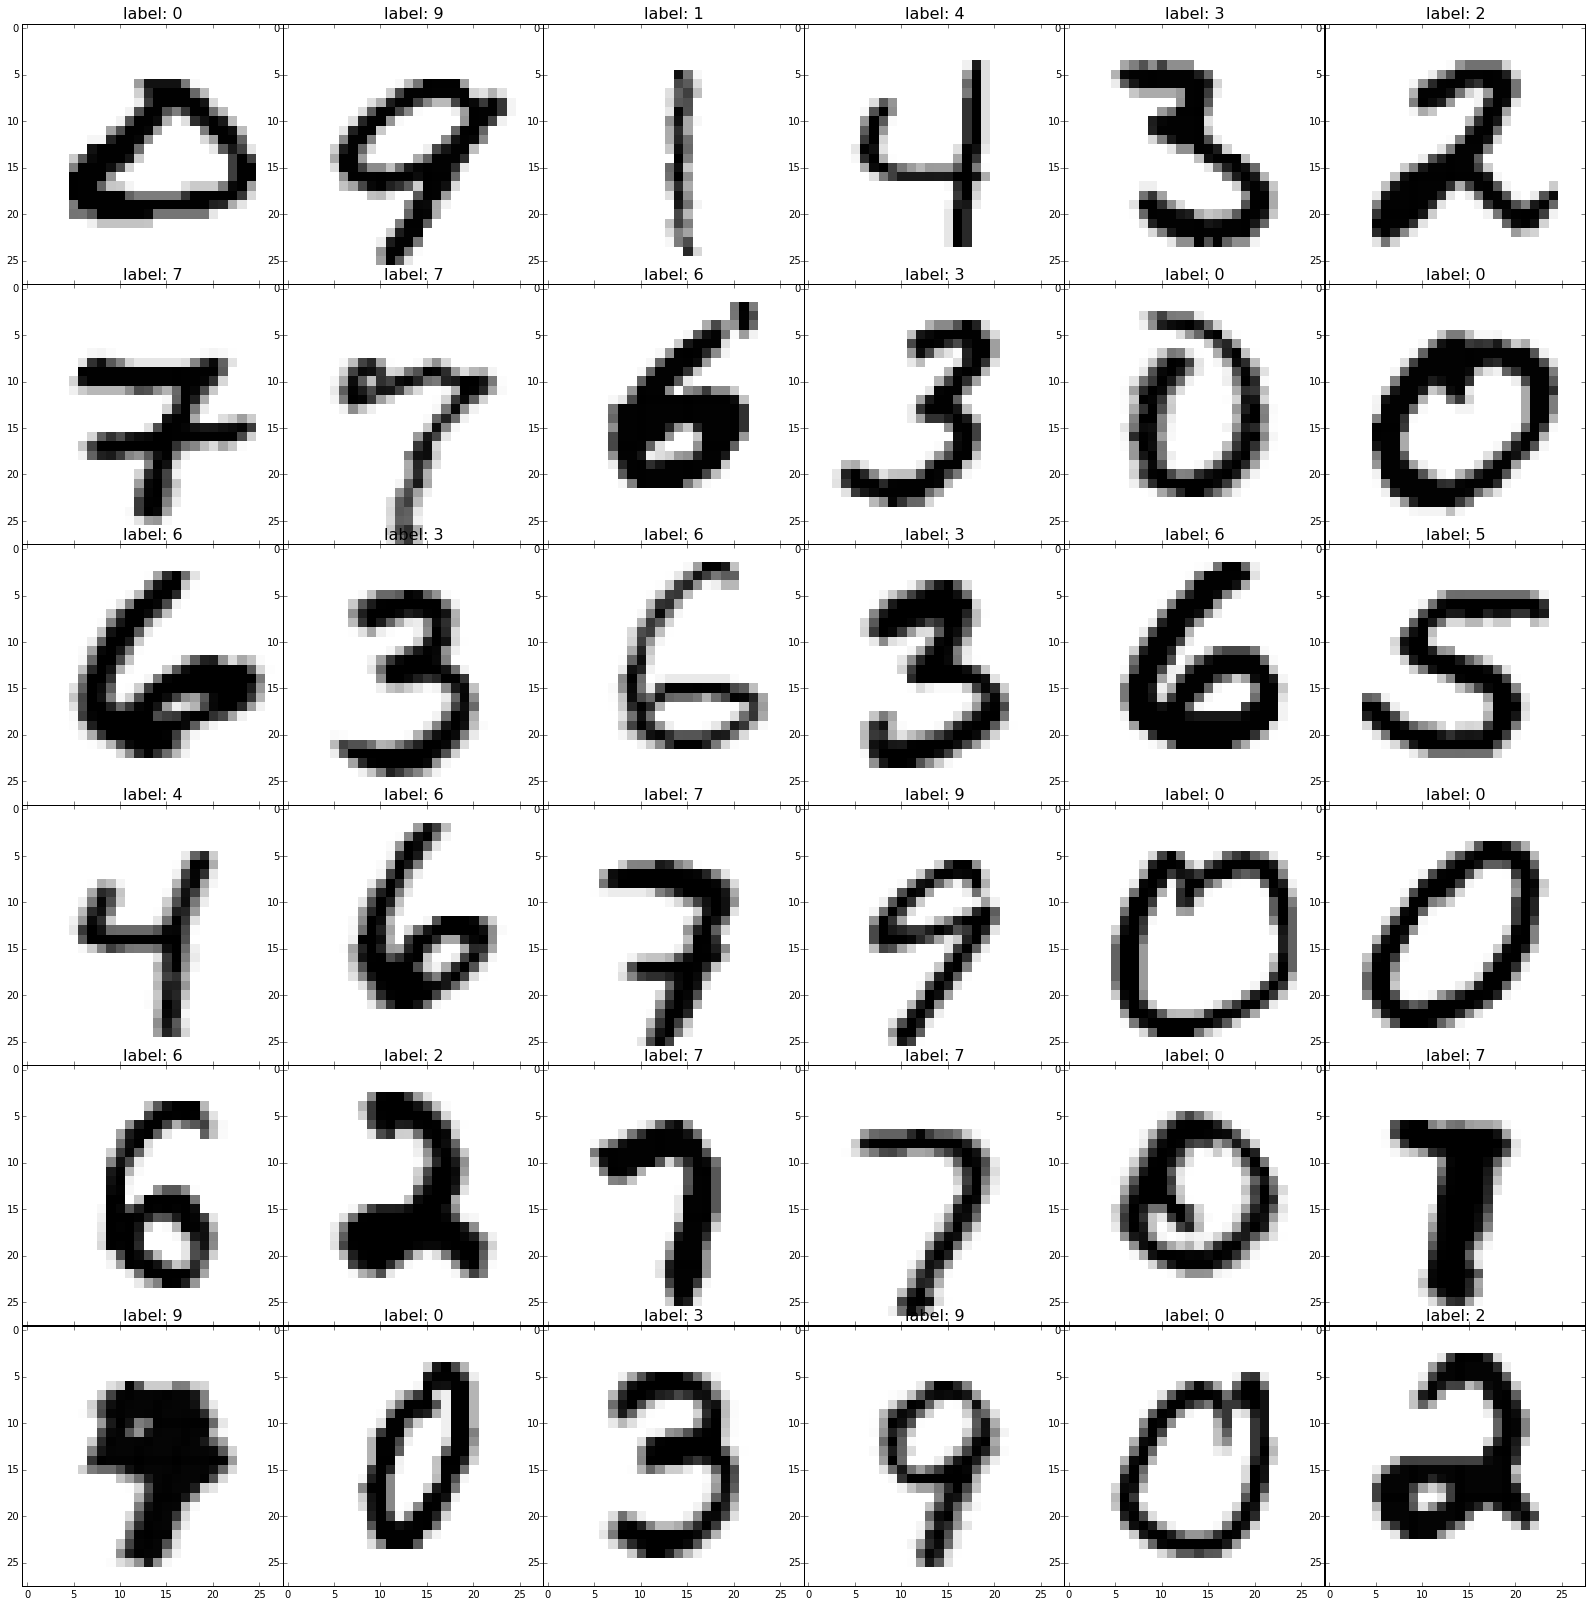

In [7]:
print_imgs(images           = trainX, 
           actual_labels    = trainY, 
           predicted_labels = trainY,
           starting_index   = np.random.randint(0, high=trainY.shape[0]-36, size=1)[0],
           size             = 6)

#PCA dimensionality reduction

In [8]:
t0 = time.time()

pca = PCA(n_components=0.85, whiten=True)

trainX = pca.fit_transform(trainX)
testX  = pca.transform(testX)

print("trainX shape: {0}".format(trainX.shape))
print("trainY shape: {0}\n".format(trainY.shape))
print("testX shape: {0}".format(testX.shape))
print("testY shape: {0}".format(testY.shape))

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))

trainX shape: (120000, 54)
trainY shape: (120000,)

testX shape: (10000, 54)
testY shape: (10000, 1)

time in minutes 0.23


#SVC Parameter Settings

In [9]:
# default parameters for SVC
# ==========================
default_svc_params = {}

default_svc_params['C']            = 1.0      # penalty
default_svc_params['class_weight'] = None     # Set the parameter C of class i to class_weight[i]*C
                                              # set to 'auto' for unbalanced classes
default_svc_params['gamma']        = 0.0      # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'

default_svc_params['kernel']       = 'rbf'    # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable
                                              # use of 'sigmoid' is discouraged
default_svc_params['shrinking']    = True     # Whether to use the shrinking heuristic.     
default_svc_params['probability']  = False    # Whether to enable probability estimates.    
default_svc_params['tol']          = 0.001    # Tolerance for stopping criterion. 
default_svc_params['cache_size']   = 200      # size of the kernel cache (in MB).

default_svc_params['max_iter']     = -1       # limit on iterations within solver, or -1 for no limit. 
  
default_svc_params['verbose']      = False 
default_svc_params['degree']       = 3        # 'poly' only
default_svc_params['coef0']        = 0.0      # 'poly' and 'sigmoid' only


# set the parameters for the classifier
# =====================================
svc_params = dict(default_svc_params)

svc_params['cache_size']  = 2000
svc_params['probability'] = True
svc_params['kernel']      = 'poly'
svc_params['C']           = 1.0
svc_params['gamma']       = 0.1112
svc_params['degree']      = 3
svc_params['coef0']       = 1


# create the classifier itself
# ============================
svc_clf = SVC(**svc_params)

##Fit the training data

In [10]:
t0 = time.time()

svc_clf.fit(trainX, trainY)

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))


time in minutes 13.36


##Predict the test set and analyze the result

In [11]:
target_names     = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

predicted_values = svc_clf.predict(testX)
y_true, y_pred   = testY, predicted_values

print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.99      0.99      0.99      1010
          4       0.98      0.99      0.99       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.98      0.98      1009

avg / total       0.99      0.99      0.99     10000



[[ 977    0    0    1    0    0    2    0    0    0]
 [   0 1127    4    1    0    0    2    0    1    0]
 [   1    1 1016    1    2    0    1    5    5    0]
 [   0    0    4  996    0    3    0    2    4    1]
 [   1    0    1    0  971    0    3    1    0    5]
 [   1    0    0    3    0  885    2    0    1    0]
 [   4    3    1    0    3    1  946    0    0    0]
 [   1    2    4    0    3    0    0 1015    0    3]
 [   3    0    1    2    1    3    0    1  960    3]
 [   4    2    1    3    8    1    1    4    1  984]]

Model accuracy: 0.9877, model misclass rate: 0.0123


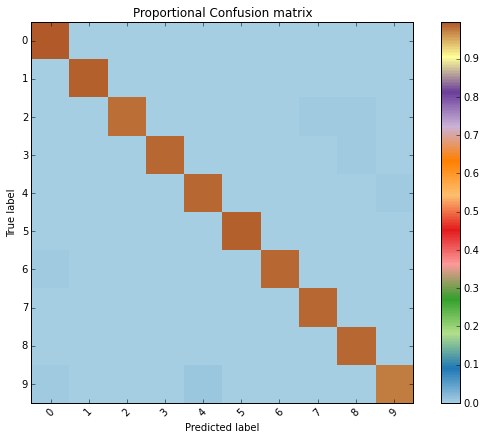

In [12]:
def plot_confusion_matrix(cm, 
                          target_names,
                          title='Proportional Confusion matrix', 
                          cmap=plt.cm.Paired):  
    """
    given a confusion matrix (cm), make a nice plot
    see the skikit-learn documentation for the original done for the iris dataset
    """
    plt.figure(figsize=(8, 6))
    plt.imshow((cm/cm.sum(axis=1)), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true, y_pred)  

print(cm)
model_accuracy = sum(cm.diagonal())/len(testY)
model_misclass = 1 - model_accuracy
print("\nModel accuracy: {0}, model misclass rate: {1}".format(model_accuracy, model_misclass))

plot_confusion_matrix(cm, target_names)

##Learning Curves

see http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

* The score is the model accuracy
* The red line shows how well the model fits the data it was trained on: 
    * a high score indicates low bias ... the model does fit the training data
        * it's not unusual for the red line to start at 1.00 and decline slightly
    * a low score indicates the model does not fit the training data ... more predictor variables are ususally indicated, or a different model
    
* The green line shows how well the model predicts the test data: if it's rising then it means more data to train on will produce better predictions

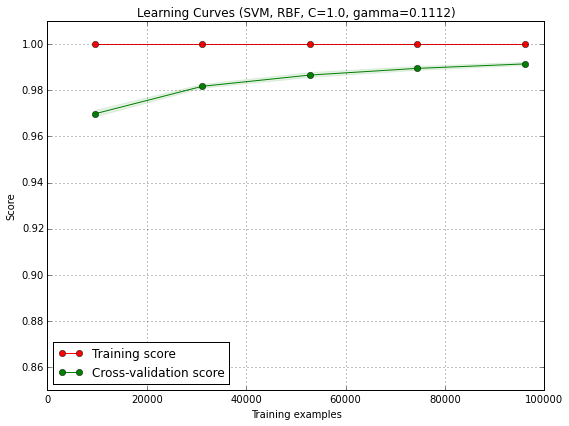


time in minutes 47.54


In [13]:
t0 = time.time()

from sklearn.learning_curve   import learning_curve
from sklearn.cross_validation import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.tight_layout()

    plt.legend(loc="best")
    return plt

C_gamma = "C="+str(np.round(svc_params['C'],4))+", gamma="+str(np.round(svc_params['gamma'],6))
title   = "Learning Curves (SVM, Poly, " + C_gamma + ")"

plot_learning_curve(estimator = svc_clf, 
                    title     = title, 
                    X         = trainX, 
                    y         = trainY, 
                    ylim      = (0.85, 1.01), 
                    cv        = ShuffleSplit(n         = trainX.shape[0], 
                                             n_iter    = 5, 
                                             test_size = 0.2, 
                                             random_state=0), 
                    n_jobs    = 8)

plt.show()

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))